In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report

In [2]:
TRAIN_PATH = '../data/raw/Train.csv'
DEFINITIONS_PATH = '../data/raw/VariableDefinitions.csv'
TARGET_COL = 'Target'

In [3]:
df = pd.read_csv(TRAIN_PATH)
df_defs = pd.read_csv(DEFINITIONS_PATH) # Load definitions to inspect feature names

In [4]:
# Convert the categorical target to ordinal integers: Low (0), Medium (1), High (2)
target_map = {'Low': 0, 'Medium': 1, 'High': 2}
df[TARGET_COL] = df[TARGET_COL].map(target_map)

In [5]:
# Define the inverse map for reporting
INVERSE_MAP = {v: k for k, v in target_map.items()}

In [6]:
print(f"Data Loaded. Total Rows: {len(df)}")
print("-" * 30)
print(f"Target Distribution (0=Low, 1=Medium, 2=High):\n{df[TARGET_COL].value_counts(normalize=True).sort_index() * 100}")
print("-" * 30)
print("--- FIRST 5 FEATURE NAMES & DEFINITIONS ---")
# Display the first few rows of the VariableDefinitions file
print(df_defs.head())
print("-" * 30)

# Print all column names for manual identification
print("ALL AVAILABLE COLUMNS:")
print(df.columns.tolist())

# Store the baseline feature and target names
FEATURES = [col for col in df.columns if col not in ['ID', TARGET_COL]]
X = df[FEATURES]
y = df[TARGET_COL]

Data Loaded. Total Rows: 9618
------------------------------
Target Distribution (0=Low, 1=Medium, 2=High):
Target
0    65.294240
1    29.819089
2     4.886671
Name: proportion, dtype: float64
------------------------------
--- FIRST 5 FEATURE NAMES & DEFINITIONS ---
                          VARIABLE_NAME  \
0                                    ID   
1                               country   
2                             owner_age   
3  attitude_stable_business_environment   
4             attitude_worried_shutdown   

                                VARIABLE_DESCRIPTION  
0         Unique identifier for each business record  
1  Country where the business is located (Eswatin...  
2                 Age of the business owner in years  
3  Owner attitude: Country will have a stable bus...  
4  Owner attitude: Worried that the business will...  
------------------------------
ALL AVAILABLE COLUMNS:
['ID', 'country', 'owner_age', 'attitude_stable_business_environment', 'attitude_worried_

Subset created. Rows: 3338
Features transformed using log1p(x) after median imputation for plotting.
--------------------------------------------------


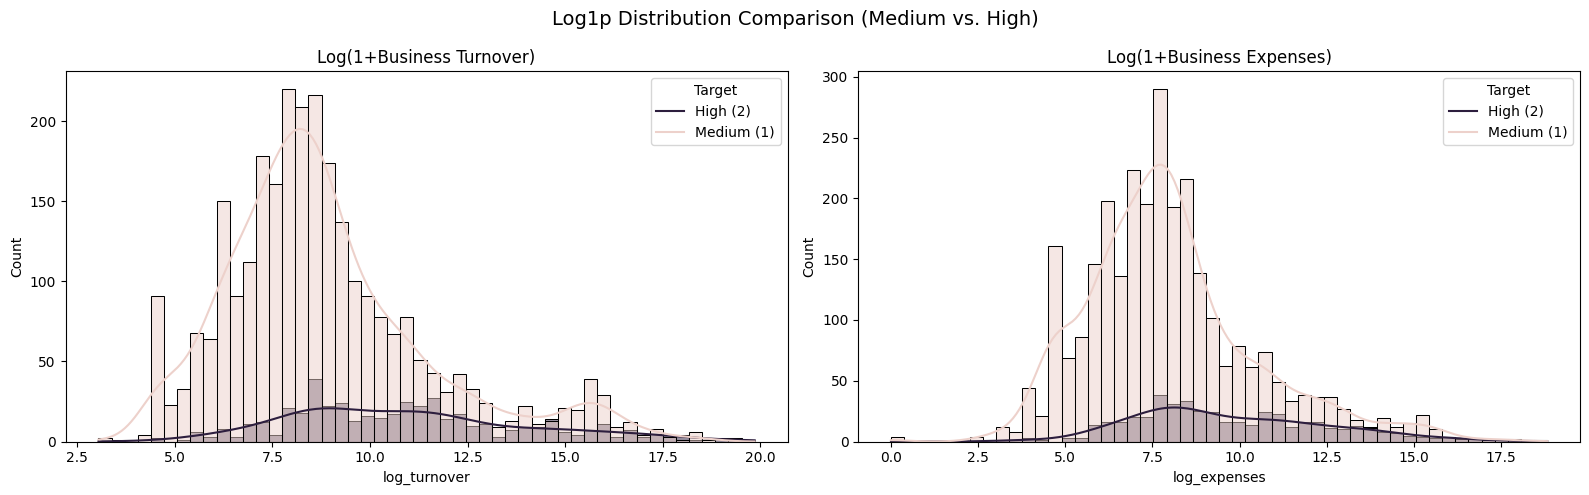

--------------------------------------------------
4. Country Breakdown of High Class (Is it country-specific?)
Target        High    Medium
country                     
eswatini  0.236336  0.763664
malawi    0.214286  0.785714
zimbabwe  0.074300  0.925700
lesotho   0.007792  0.992208


In [10]:
# --- Configuration ---
TARGET_COL = 'Target'
INVERSE_MAP = {0: 'Low', 1: 'Medium', 2: 'High'}

# 1. Subset the data to focus on the 'Medium' (1) and 'High' (2) classes
df_subset = df[df[TARGET_COL] >= 1].copy()

# 2. Impute and Log-Transform the Features (Log(1+x) handles zero and missing values safely)
expense_median = df_subset['business_expenses'].median()

# Create NEW log-transformed features for plotting
df_subset['log_turnover'] = np.log1p(df_subset['business_turnover'])
# Impute NaNs with median THEN apply log1p
df_subset['log_expenses'] = np.log1p(df_subset['business_expenses'].fillna(expense_median)) 

print(f"Subset created. Rows: {len(df_subset)}")
print(f"Features transformed using log1p(x) after median imputation for plotting.")
print("-" * 50)

# 3. Check the distributions of Log-Transformed Turnover and Expenses
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plt.suptitle('Log1p Distribution Comparison (Medium vs. High)', fontsize=14)

# Plot 1: Log(Turnover)
sns.histplot(data=df_subset, x='log_turnover', hue=TARGET_COL, kde=True, bins=50, ax=axes[0])
axes[0].set_title('Log(1+Business Turnover)')
axes[0].legend(title='Target', labels=['High (2)', 'Medium (1)'])

# Plot 2: Log(Expenses)
sns.histplot(data=df_subset, x='log_expenses', hue=TARGET_COL, kde=True, bins=50, ax=axes[1])
axes[1].set_title('Log(1+Business Expenses)')
axes[1].legend(title='Target', labels=['High (2)', 'Medium (1)'])

plt.tight_layout()
plt.show()

print("-" * 50)
print("4. Country Breakdown of High Class (Is it country-specific?)")
# Groupby/Crosstab to see the percentage of the High class within each Country
country_target_crosstab = pd.crosstab(
    df_subset['country'], 
    df_subset[TARGET_COL].map(INVERSE_MAP), 
    normalize='index' # Normalize by row (Country total) to see FHI distribution within a country
)

print(country_target_crosstab.sort_values(by='High', ascending=False))